In [360]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import neal
import re

In [361]:
import warnings
warnings.filterwarnings("ignore")

In [362]:
path = '/Users/phuntrakaool/Downloads/world-cities-database/country.csv'

In [363]:
df = pd.read_csv(path)

In [525]:
n = 15
cluster_size = 2

In [526]:
us = df[(df['Country']=='us') & (df['Region']=='CA')].sample(frac=1).reset_index(drop=True)[:n]
us['Adj_Long'] = (us['Longitude']-us['Longitude'].mean())*10
us['Adj_Lat'] = (us['Latitude']-us['Latitude'].mean())*10

In [527]:
us

,Unnamed: 0,Country,City,AccentCity,Region,Population,Latitude,Longitude,Adj_Long,Adj_Lat
0,2920731,us,malibu hills,Malibu Hills,CA,NaN,34.047500,-118.743333,20.146482,-38.539445
1,2922701,us,taylorsville,Taylorsville,CA,NaN,40.075556,-120.838611,-0.806296,21.741111
2,2918633,us,card place,Card Place,CA,NaN,39.808056,-123.403611,-26.456296,19.066111
3,2918574,us,cameron creek colony,Cameron Creek Colony,CA,NaN,36.317222,-119.203889,15.540926,-15.842223
4,2920057,us,homestead,Homestead,CA,NaN,41.913611,-121.421944,-6.639629,40.121666
5,2919098,us,deetz,Deetz,CA,NaN,41.358056,-122.382222,-16.242407,34.566111
6,2919131,us,denair,Denair,CA,NaN,37.526389,-120.795833,-0.378518,-3.750556
7,2921339,us,oceanview,Oceanview,CA,NaN,37.709444,-122.437500,-16.795185,-1.920001
8,2919281,us,east oakdale,East Oakdale,CA,NaN,37.788056,-120.802778,-0.447963,-1.133889
9,2919977,us,hessel,Hessel,CA,NaN,38.348333,-122.776111,-20.181296,4.468888


In [528]:
df1 = us.loc[:,['Adj_Long','Adj_Lat']]

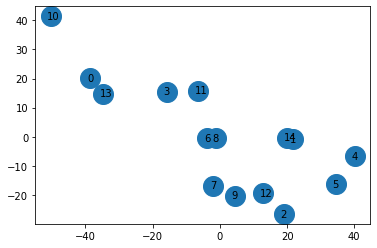

In [529]:
fig, ax = plt.subplots()
ax.scatter(x="Adj_Lat", y="Adj_Long", data=df1, s=400)
for line in range(0,df1.shape[0]):
     ax.annotate(line, (df1['Adj_Lat'][line]-1, df1['Adj_Long'][line]-1))
    

In [530]:
def dist(x1,y1,x2,y2):
    return np.round(np.sqrt((x1-x2)**2+(y1-y2)**2))

In [531]:
kmeans = KMeans(n_clusters=cluster_size, n_init=200)
kmeans.fit(df1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=200, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [532]:
labels = kmeans.predict(df1)

In [534]:
df1['cluster'] = labels

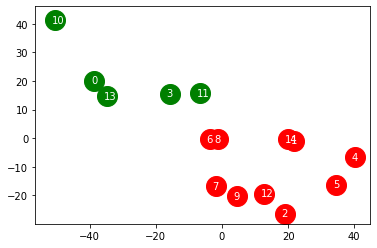

In [535]:
colmap = {0: 'r', 1: 'g', 2: 'b'}

fig, ax = plt.subplots()
for i in list(range(0,cluster_size)):
    ax.scatter(x="Adj_Lat", y="Adj_Long", data=df1[df1["cluster"]==i], s=400, color = colmap[i])
for line in range(0,df1.shape[0]):
     ax.annotate(line, (df1['Adj_Lat'][line]-1, df1['Adj_Long'][line]-1), color = "w")

In [536]:
cl = list(range(0,cluster_size))
cl 

[0, 1]

### Shortest Path

In [537]:
c = 1
use = df1[df1['cluster'] == c].append(df1.loc[0,:]).drop_duplicates()

In [538]:
from collections import defaultdict
modify_node = defaultdict(int)
for index,u in zip(range(len(use)) ,use.index):
    modify_node[index] = u

In [539]:
modify_node

defaultdict(int, {0: 0, 1: 3, 2: 10, 3: 11, 4: 13})

In [540]:
G = nx.complete_graph(len(use))

In [541]:
for (u, v) in G.edges():
    x1,y1 = use.loc[modify_node[u],["Adj_Lat","Adj_Long"]]
    x2,y2 = use.loc[modify_node[v],["Adj_Lat","Adj_Long"]]
    G.edges[u,v]['weight'] = dist(x1,y1,x2,y2)

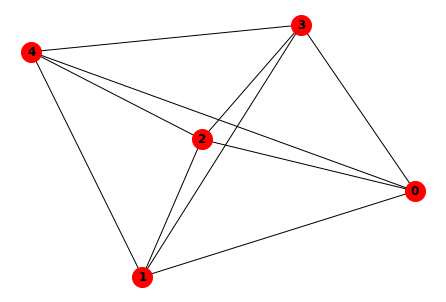

In [542]:
nx.draw(G, node_size=400, node_color='red', with_labels=True, font_weight='bold')
plt.show()

In [543]:
DistMat = nx.adjacency_matrix(G).todense()
DistMat

matrix([[ 0., 23., 24., 32.,  7.],
        [23.,  0., 43.,  9., 19.],
        [24., 43.,  0., 51., 31.],
        [32.,  9., 51.,  0., 28.],
        [ 7., 19., 31., 28.,  0.]])

## Travel Salemans Problem

### Objective Function 
$H_A=A\sum_{i=1}^n(1-\sum_{j=1}^nx_{i,j})^2+A\sum_{j=1}^n(1-\sum_{i=1}^nx_{i,j})^2$ <br>
$H_B=B\sum_{ui\in E}^nD_{ui}(\sum_{j=1}x_{u,j}x_{i,j+1})$ <br>
<br>
min $H = H_A+H_B$




In [597]:
def sa_solver(bqm):
    sampler = neal.SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)
    min_energy = float("inf")
    current_solution = []
    for sample, energy in response.data(['sample', 'energy']):
        if energy < min_energy:
            current_solution = sample
            min_energy = energy
    return current_solution

In [598]:
def display_mat(current_solution, DistMat, modify_node):
    ans_mat = np.zeros((len(DistMat),len(DistMat)))
    for key,val in current_solution.items():
        temp = re.findall(r'\d+', key) 
        x,y = list(map(int, temp))
        ans_mat[x,y] = val
        ans_mat[y,x] = val
    print(ans_mat)
    route = list(np.argmax(ans_mat, axis=0))
    route.append(route[0])
    route = [modify_node[i] for i in route]
    edges = []
    for x in range(len(route)-1):
        edges.append((route[x],route[x+1]))
#     G = nx.Graph()
#     G.add_edges_from(edges)
#     nx.draw_circular(G, node_size=400, node_color='red', with_labels=True, font_weight='bold')
#     plt.show()
    return route, list(edges)

In [602]:
def shortest_path(df1, c):
    use = df1[df1['cluster'] == c].append(df1.loc[0,:]).drop_duplicates()  
    from collections import defaultdict
    modify_node = defaultdict(int)
    for index,u in zip(range(len(use)) ,use.index):
        modify_node[index] = u
    G = nx.complete_graph(len(use))
    for (u, v) in G.edges():
        x1,y1 = use.loc[modify_node[u],["Adj_Lat","Adj_Long"]]
        x2,y2 = use.loc[modify_node[v],["Adj_Lat","Adj_Long"]]
        G.edges[u,v]['weight'] = dist(x1,y1,x2,y2)
    DistMat = nx.adjacency_matrix(G).todense()
    size = (len(DistMat),len(DistMat))
    x = Array.create('x', size, "BINARY")
    HA_1 = 0
    HA_2 = 0
    for i in range(len(DistMat)):
        temp_1 = 1
        temp_2 = 1
        for j in range(len(DistMat)):
            temp_1 -= x[i][j]
            temp_2 -= x[j][i]
        HA_1 += temp_1**2
        HA_2 += temp_2**2
    HB = 0
    for u,i in list(G.edges):
        temp = 0
        for j in range(0,len(DistMat)-1):
            temp += x[u][j]*x[i][j+1]
        HB += DistMat.item((u, i))*temp
    max_distance = DistMat.max()
    B = 1
    A = (max_distance)*len(DistMat)#max_distance*(len(DistMat))
    H = A*(HA_1 + HA_2) + B*HB
    model = H.compile()
    bqm = model.to_dimod_bqm()
    current_solution = sa_solver(bqm)
    route, edges = display_mat(current_solution, DistMat, modify_node)
    return edges
    

0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
1
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


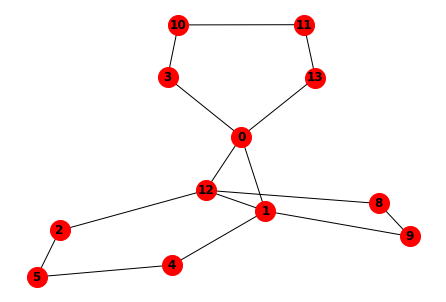

In [603]:
edges = []
for c in cl:
    print(c)
    edges+=shortest_path(df1, c)
G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, node_size=400, node_color='red', with_labels=True, font_weight='bold')
plt.show()

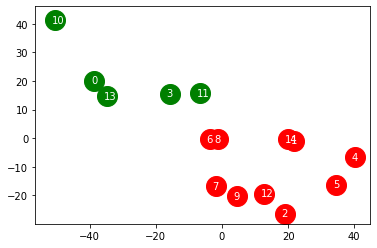

In [601]:
colmap = {0: 'r', 1: 'g', 2: 'b'}

fig, ax = plt.subplots()
for i in list(range(0,cluster_size)):
    ax.scatter(x="Adj_Lat", y="Adj_Long", data=df1[df1["cluster"]==i], s=400, color = colmap[i])
for line in range(0,df1.shape[0]):
     ax.annotate(line, (df1['Adj_Lat'][line]-1, df1['Adj_Long'][line]-1), color = "w")